In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_train=pd.read_csv('data/raw/train.csv')
df_test=pd.read_csv('data/raw/test.csv')

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df_train['CryoSleep']=df_train['CryoSleep'].astype(bool).astype(int)
df_train['VIP']=df_train['VIP'].astype(bool).astype(int)
df_train['Transported']=df_train['Transported'].astype(int)

In [7]:
df_train['Cabin_deck']=df_train['Cabin'].str.split('/', expand=True)[0]
df_train['Cabin_num']=df_train['Cabin'].str.split('/', expand=True)[1]
df_train['Cabin_side']=df_train['Cabin'].str.split('/', expand=True)[2]

In [8]:
df_train['GroupId']=df_train['PassengerId'].str.split('_', expand=True)[0]
passenger_ids=df_train['PassengerId'].str.split('_', expand=True)
passenger_ids=passenger_ids.groupby(0)[1].max().astype(int).reset_index().rename(columns={0:'GroupId', 1:'people_in_group'})

df_train=pd.merge(df_train, passenger_ids, how = 'left', on = ['GroupId'])

In [9]:
print('Total Ids in Training Dataset:', len(df_train))
print('Total Ids in Passenger IDs Dataset:', passenger_ids['people_in_group'].sum())

Total Ids in Training Dataset: 8693
Total Ids in Passenger IDs Dataset: 8693


In [10]:
df_train['Last_name']=df_train['Name'].str.split(' ', expand=True)[1]
families=df_train['Name'].str.split(' ', expand=True)
families=families.groupby(1)[0].count().reset_index().rename(columns={0:'family_members', 1:'Last_name'})

df_train=pd.merge(df_train, families, how = 'left', on = ['Last_name'])

In [11]:
cabin_vol=df_train.groupby(['Cabin_num'])['PassengerId'].count().reset_index().rename(columns={'PassengerId':'people_in_cabin'})
df_train=pd.merge(df_train, cabin_vol, how = 'left', on = ['Cabin_num'])

In [12]:
df_train['total_value_spent']=df_train[['RoomService',	'FoodCourt',	'ShoppingMall',	'Spa']].sum(axis=1)
df_train['spent_any']=np.where(df_train['total_value_spent']>0,1,0)

In [13]:
df_train['Alone']=np.where((df_train['people_in_group']==1) & (df_train['family_members']==1),1,0)
df_train['Private_cabin']=np.where(df_train['people_in_cabin']==1,1,0)

In [14]:
df_train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin
count,8693.000000,8514.000000,8693.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8493.000000,8494.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.374324,28.827930,0.046244,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,2.035546,5.428117,8.037203,1142.604509,0.574255,0.039687,0.030829
std,0.483976,14.489021,0.210025,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,1.596347,2.891901,5.214669,2327.986241,0.494484,0.195234,0.172865
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,7.000000,420.000000,1.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,3.000000,7.000000,12.000000,1193.000000,1.000000,0.000000,0.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,8.000000,18.000000,28.000000,35970.000000,1.000000,1.000000,1.000000


In [15]:
target = 'Transported'

In [16]:
df_train.groupby('HomePlanet')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
HomePlanet,,
Earth,4602,0.423946
Mars,1759,0.523024
Europa,2131,0.658846


In [17]:
df_train.groupby('Destination')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
Destination,,
TRAPPIST-1e,5915,0.471175
PSO J318.5-22,796,0.503769
55 Cancri e,1800,0.610000


In [18]:
df_train.groupby('VIP')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
VIP,,
1,402,0.447761
0,8291,0.506332


In [19]:
df_train.groupby('CryoSleep')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
CryoSleep,,
0,5439,0.328921
1,3254,0.795636


In [20]:
df_train.groupby(pd.qcut(df_train['Age'], 10))[target].agg(['count', 'mean'])

,count,mean
Age,,
"(-0.001, 13.0]",947,0.671595
"(13.0, 18.0]",918,0.541394
"(18.0, 21.0]",881,0.442679
"(21.0, 24.0]",907,0.452040
"(24.0, 27.0]",770,0.483117
"(27.0, 31.0]",882,0.484127
"(31.0, 35.0]",696,0.481322
"(35.0, 41.0]",911,0.478595
"(41.0, 49.0]",791,0.494311


In [21]:
df_train.groupby(pd.qcut(df_train['RoomService'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
RoomService,,
"(-0.001, 1.0]",5694,0.627327
"(1.0, 29.0]",551,0.353902
"(29.0, 175.6]",564,0.370567
"(175.6, 553.0]",570,0.263158
"(553.0, 1044.8]",565,0.180531
"(1044.8, 14327.0]",568,0.117958


In [22]:
df_train.groupby(pd.qcut(df_train['ShoppingMall'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
ShoppingMall,,
"(-0.001, 1.0]",5740,0.589199
"(1.0, 16.0]",490,0.240816
"(16.0, 97.0]",559,0.205725
"(97.0, 397.0]",565,0.223009
"(397.0, 804.4]",565,0.387611
"(804.4, 23492.0]",566,0.537102


In [23]:
df_train.groupby(pd.qcut(df_train['VRDeck'], 15, duplicates='drop'))[target].mean()

VRDeck
(-0.001, 2.0]          0.618338
(2.0, 27.0]            0.346296
(27.0, 156.2]          0.355357
(156.2, 514.133]       0.296296
(514.133, 1140.067]    0.231041
(1140.067, 24133.0]    0.119929
Name: Transported, dtype: float64

In [24]:
df_train.groupby(['spent_any', 'CryoSleep'])[target].mean().unstack(1)

CryoSleep,0,1
spent_any,,
0,0.572438,0.814673
1,0.300636,0.294118


In [25]:
df_train.groupby(['Cabin_side', 'Cabin_deck'])[target].mean().unstack(1)

Cabin_deck,A,B,C,D,E,F,G,T
Cabin_side,,,,,,,,
P,0.435897,0.674221,0.580645,0.403226,0.342657,0.410987,0.448276,0.25
S,0.546763,0.784038,0.763547,0.465217,0.371365,0.470501,0.583788,0.00


Data Viz

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


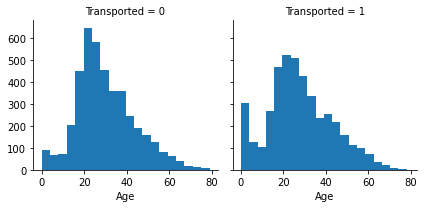

In [26]:
g = sns.FacetGrid(df_train, col=target)
g.map(plt.hist, 'Age', bins=20)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


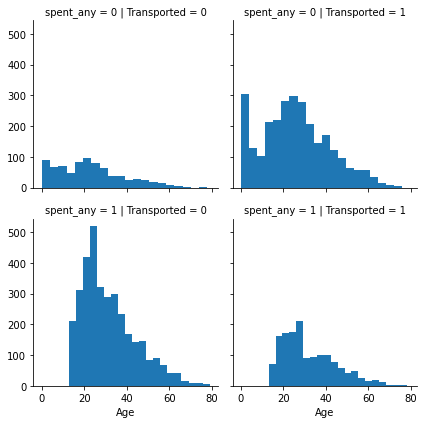

In [27]:
g = sns.FacetGrid(df_train, col=target, row='spent_any')
g.map(plt.hist, 'Age', bins=20)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


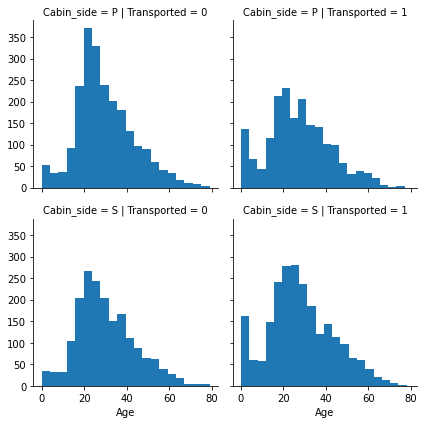

In [28]:
g = sns.FacetGrid(df_train, col=target, row='Cabin_side')
g.map(plt.hist, 'Age', bins=20)

Data Manipulation 

In [29]:
df_train.dtypes

PassengerId           object
HomePlanet            object
CryoSleep              int32
Cabin                 object
Destination           object
Age                  float64
VIP                    int32
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Name                  object
Transported            int32
Cabin_deck            object
Cabin_num             object
Cabin_side            object
GroupId               object
people_in_group        int32
Last_name             object
family_members       float64
people_in_cabin      float64
total_value_spent    float64
spent_any              int32
Alone                  int32
Private_cabin          int32
dtype: object

In [30]:
cols_dummies = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side']
df_train[cols_dummies]=df_train[cols_dummies].fillna('NULL')

In [31]:
df_train=pd.get_dummies(df_train, columns=cols_dummies, drop_first='True')

In [32]:
corr=df_train.select_dtypes(np.number).corr()
corr[target].sort_values()

spent_any                   -0.471868
RoomService                 -0.244611
Spa                         -0.221131
VRDeck                      -0.207075
total_value_spent           -0.140420
Cabin_side_P                -0.101397
Cabin_deck_E                -0.097965
Destination_TRAPPIST-1e     -0.094700
Cabin_deck_F                -0.087753
Age                         -0.075026
Private_cabin               -0.037231
Cabin_deck_D                -0.034046
family_members              -0.033312
VIP                         -0.024602
Cabin_deck_T                -0.014568
Cabin_deck_NULL             -0.000340
Destination_PSO J318.5-22    0.000092
Destination_NULL             0.000547
HomePlanet_NULL              0.002712
ShoppingMall                 0.010141
Cabin_deck_G                 0.016269
HomePlanet_Mars              0.019544
Alone                        0.027401
FoodCourt                    0.046566
people_in_cabin              0.078296
people_in_group              0.082644
Cabin_side_S

In [33]:
corr

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NULL,Destination_NULL,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_NULL,Cabin_deck_T,Cabin_side_P,Cabin_side_S
CryoSleep,1.000000,-0.073771,-0.050342,-0.243434,-0.204765,-0.208465,-0.199075,-0.192749,0.451744,0.082696,-0.007762,0.047185,-0.355662,-0.841104,0.009568,-0.051319,0.094665,0.031692,0.002785,-0.026775,0.085744,-0.100486,0.121837,0.031703,-0.067703,-0.110477,-0.217772,0.237359,0.026239,-0.008641,-0.019696,0.011838
Age,-0.073771,1.000000,0.058930,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,-0.179102,-0.133882,0.077054,0.175361,0.227470,0.068355,-0.002097,0.219793,0.016273,-0.000363,0.013098,-0.028503,-0.001047,0.104058,0.127957,0.077988,0.028638,-0.018938,-0.212117,0.003390,0.013673,-0.011880,0.010862
VIP,-0.050342,0.058930,1.000000,0.050854,0.089639,-0.001104,0.037446,0.087322,-0.024602,-0.001815,-0.044772,0.058413,0.092819,0.055555,0.005740,-0.020260,0.094805,0.033617,-0.004720,-0.009245,0.006058,-0.029993,0.034473,0.049751,0.043001,-0.019124,-0.035428,-0.062903,0.010245,-0.005282,0.000545,-0.003610
RoomService,-0.243434,0.068723,0.050854,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,-0.040777,-0.030852,-0.001387,0.294410,0.290126,-0.011393,0.020630,-0.068098,0.248013,-0.005029,-0.003933,-0.063655,0.061780,-0.065617,-0.020310,0.162944,0.044106,0.086898,-0.146530,0.026772,0.007364,0.007583,-0.015591
FoodCourt,-0.204765,0.130421,0.089639,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.032632,-0.102193,0.201570,0.786218,0.244413,0.036329,-0.033295,0.369477,-0.126142,-0.018768,-0.010415,-0.066214,-0.074411,0.156435,0.262541,0.020183,-0.039740,-0.133150,-0.151747,0.000343,0.014134,-0.019812,0.019700
ShoppingMall,-0.208465,0.033133,-0.001104,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,-0.038770,-0.038986,-0.012007,0.270929,0.246174,0.019616,0.020777,-0.021282,0.112464,-0.008092,-0.005794,-0.031760,0.033184,-0.010739,0.000934,0.055252,0.031655,0.074909,-0.109245,-0.010420,-0.006222,0.022192,-0.019041
Spa,-0.199075,0.123970,0.037446,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.019223,-0.067941,0.139243,0.642615,0.236032,0.040532,-0.024183,0.269178,-0.089063,-0.010778,0.007079,-0.053976,-0.034859,0.115679,0.165828,0.034564,-0.011814,-0.088352,-0.125876,0.025807,0.036205,-0.005801,-0.001964
VRDeck,-0.192749,0.101007,0.087322,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.009401,-0.074972,0.127231,0.217949,0.217276,0.029496,-0.018154,0.284801,-0.113128,-0.002701,-0.010777,-0.045816,-0.047128,0.123204,0.208311,-0.003495,-0.018676,-0.095165,-0.128630,-0.007280,0.012239,0.009073,-0.006890
Transported,0.451744,-0.075026,-0.024602,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,0.082644,-0.033312,0.078296,-0.140420,-0.471868,0.027401,-0.037231,0.176916,0.019544,0.002712,0.000547,0.000092,-0.094700,0.144733,0.108193,-0.034046,-0.097965,-0.087753,0.016269,-0.000340,-0.014568,-0.101397,0.101455
people_in_group,0.082696,-0.179102,-0.001815,-0.040777,0.032632,-0.038770,0.019223,0.009401,0.082644,1.000000,0.343033,0.296143,0.010398,-0.186039,-0.131882,-0.095692,0.132389,-0.021261,-0.002467,-0.004263,-0.057293,-0.014721,0.079807,0.104512,-0.005688,-0.064911,-0.124731,0.039220,0.019721,-0.015563,-0.017522,0.011615


In [37]:
df_train.to_csv('data/intermediate/train_dataset.csv',index=False)

Fitting models

In [34]:
train_cols = list(df_train.select_dtypes(np.number).drop(target,axis=1).columns)

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[train_cols].fillna(-1), df_train[target], test_size=0.3)

In [36]:
X_train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NULL,Destination_NULL,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_NULL,Cabin_deck_T,Cabin_side_P,Cabin_side_S
count,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000
mean,0.373377,28.200493,0.046836,226.537058,455.482334,173.380444,311.345275,298.447329,2.006738,5.235004,7.820378,1166.832703,0.580115,0.039934,0.032703,0.244207,0.203615,0.024651,0.021200,0.093509,0.677896,0.088578,0.087592,0.057190,0.099260,0.325883,0.289565,0.023500,0.000657,0.485292,0.491208
std,0.483741,14.731664,0.211306,675.667947,1591.320117,620.323467,1167.257120,1122.486772,1.567500,2.986765,5.349591,2374.847776,0.493580,0.195821,0.177874,0.429651,0.402719,0.155071,0.144061,0.291168,0.467321,0.284158,0.282724,0.232224,0.299036,0.468742,0.453598,0.151499,0.025633,0.499825,0.499964
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,6.000000,465.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,0.000000,44.000000,60.000000,23.000000,56.000000,43.000000,2.000000,7.000000,12.000000,1212.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,27723.000000,23492.000000,18572.000000,24133.000000,8.000000,18.000000,28.000000,27928.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Logistic regression
 Train Set Accuracy: 0.78
Logistic regression
 Validation Set Accuracy: 0.79


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


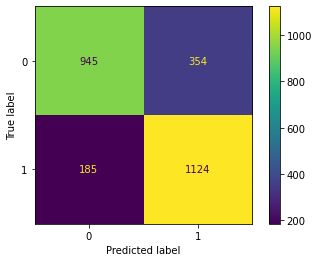

In [37]:
# Logistic Regression
m_logreg = LogisticRegression(random_state=42)
m_logreg = m_logreg.fit(X_train, y_train)

pred_train_logreg = m_logreg.predict(X_train)
pred_logreg = m_logreg.predict(X_valid)

cm = confusion_matrix(y_valid, pred_logreg, labels=m_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_logreg.classes_)
disp.plot()
print("Logistic regression\n Train Set Accuracy:", round(accuracy_score(y_train, pred_train_logreg), 2) )
print("Logistic regression\n Validation Set Accuracy:", round(accuracy_score(y_valid, pred_logreg), 2) )

Random Forest
 Train Set Accuracy: 1.0
Random Forest
 Validation Set Accuracy: 0.8


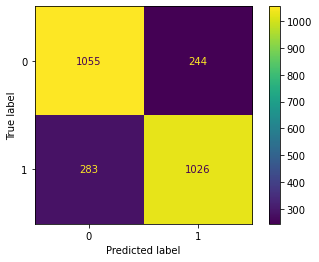

In [41]:
# Random Forest
m_rf = RandomForestClassifier(random_state=42)
m_rf = m_rf.fit(X_train, y_train)

pred_train_rf = m_rf.predict(X_train)
pred_rf = m_rf.predict(X_valid)

cm = confusion_matrix(y_valid, pred_rf, labels=m_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_rf.classes_)
disp.plot()
print("Random Forest\n Train Set Accuracy:", round(accuracy_score(y_train, pred_train_rf), 2) )
print("Random Forest\n Validation Set Accuracy:", round(accuracy_score(y_valid, pred_rf), 2) )

In [42]:
mod_xgb = xgb.XGBClassifier(random_state=42)

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 15, name='max_depth'),
          Real(0.025, 0.30, name='learning_rate'),
          Integer(1, 7, name='min_child_weight'),
          Real(0, 0.40, name='learning_rate'),
          Real(0.3, 0.7, name='colsample_bytree')
          ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    mod_xgb.set_params(**params)

    return -np.mean(cross_val_score(mod_xgb, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [43]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=-0.7985'

In [44]:
list_pars_xgb=['max_depth','learning_rate','min_child_weight', 'learning_rate','colsample_bytree']
best_pars_xgb=dict(zip(list_pars_xgb, res_gp.x))

Xgboost with hypertuning
Train Accuracy: 0.95
Xgboost with hypertuning
Valid Accuracy: 0.8


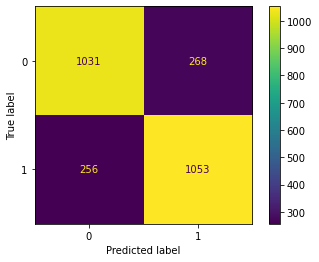

In [45]:
xgb_opt=xgb.XGBClassifier(random_state=42)
xgb_opt.fit(X_train, y_train)

pred_xgb_train = xgb_opt.predict(X_train)
pred_xgb_tuned = xgb_opt.predict(X_valid)

cm = confusion_matrix(y_valid, pred_xgb_tuned, labels=xgb_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_opt.classes_)
disp.plot()
print("Xgboost with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_xgb_train), 2) )
print("Xgboost with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_xgb_tuned), 2) )

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


One or more of the test scores are non-finite: [       nan 0.78521141 0.79523431 0.77650403 0.79129451 0.78768095
 0.78258145        nan 0.75349932 0.78882983 0.79589653 0.79786832
 0.79161832        nan        nan 0.79540095 0.7850464  0.79474251
 0.77551557 0.79540068 0.78882956 0.79540473 0.77305224        nan
 0.77650403 0.79047133 0.78619339 0.80411319        nan        nan
 0.78126809 0.79260868 0.79228108 0.79770115        nan 0.77486064
        nan        nan 0.79392123 0.79079947 0.7914579  0.79572584
 0.79917979 0.80000243 0.78159893 0.78405956 0.79556623 0.79063256
        nan 0.79556488 0.7835683         nan 0.79802659 0.79490861
 0.75284196 0.78521708 0.79309832 0.77518743 0.79737409 0.79638698
 0.79227703 0.78701819 0.79588951 0.79227622 0.74495533        nan
 0.79309886 0.78718672        nan        nan 0.75974473 0.79523837
        nan 0.79836093        nan        nan 0.79195132        nan
 0.74150327 0.79885111 0.79474224 0.79704623        nan        nan
 0.79342834 0.7

[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
LightGBM with hypertuning
Train Accuracy: 0.83
LightGBM with hypertuning
Valid Accuracy: 0.81


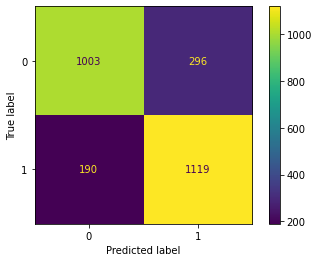

In [49]:
m_lgb = lgb.LGBMClassifier()

random_grid = {'learning_rate': [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               'max_depth': [3, 4, 5, 6, 8, 10, 12, 15, 20],
               #'num_leaves': [3, 6, 9, 12, 20, 40],
               'min_child_weight': [1, 3, 5, 7],
               'boosting':['rf', 'dart', 'gbdt'],
               'bagging_fraction':[0, 0.25, 0.5, 0.75, 0.90],
               'bagging_freq':[0, 5, 10, 15],
               'n_iterations':[5, 10, 20, 30, 60],
               #'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
               'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

lgb_random = RandomizedSearchCV(estimator = m_lgb, 
                                scoring='accuracy', 
                                param_distributions = random_grid, n_iter = 1000, cv = 10, verbose=2, random_state=42, n_jobs = -1)
lgb_random.fit(X_train, y_train)

pred_lgb_train = lgb_random.predict(X_train)
pred_lgb_tuned = lgb_random.predict(X_valid)

cm = confusion_matrix(y_valid, pred_lgb_tuned, labels=lgb_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb_random.classes_)
disp.plot()
print("LightGBM with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_lgb_train), 2) )
print("LightGBM with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_lgb_tuned), 2) )

In [54]:
lgb_random.best_estimator_

LGBMClassifier(bagging_fraction=0.5, bagging_freq=0, boosting='dart',
               colsample_bytree=0.7, learning_rate=0.2, max_depth=4,
               min_child_weight=1, n_iterations=30)

[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
LightGBM with hypertuning
Train Accuracy: 0.83
LightGBM with hypertuning
Valid Accuracy: 0.81


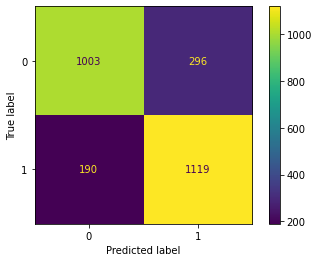

In [55]:
lgb_final=lgb_random.best_estimator_

lgb_final.fit(X_train, y_train)

pred_lgb_train = lgb_final.predict(X_train)
pred_lgb_tuned = lgb_final.predict(X_valid)

cm = confusion_matrix(y_valid, pred_lgb_tuned, labels=lgb_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb_final.classes_)
disp.plot()
print("LightGBM with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_lgb_train), 2) )
print("LightGBM with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_lgb_tuned), 2) )

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


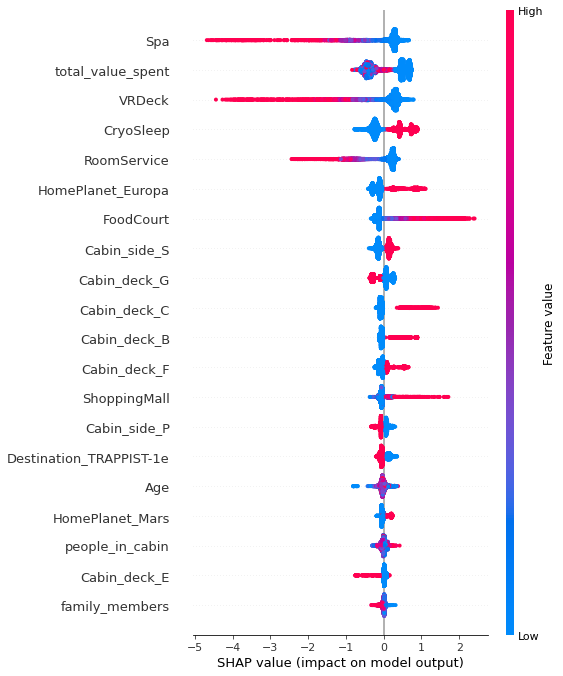

In [67]:
explainer = shap.Explainer(lgb_final)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train)

Test prediction

In [38]:
df_test['CryoSleep']=df_test['CryoSleep'].astype(bool).astype(int)
df_test['VIP']=df_test['VIP'].astype(bool).astype(int)

df_test['Cabin_deck']=df_test['Cabin'].str.split('/', expand=True)[0]
df_test['Cabin_num']=df_test['Cabin'].str.split('/', expand=True)[1]
df_test['Cabin_side']=df_test['Cabin'].str.split('/', expand=True)[2]

df_test['GroupId']=df_test['PassengerId'].str.split('_', expand=True)[0]
passenger_ids=df_test['PassengerId'].str.split('_', expand=True)
passenger_ids=passenger_ids.groupby(0)[1].max().astype(int).reset_index().rename(columns={0:'GroupId', 1:'people_in_group'})

df_test=pd.merge(df_test, passenger_ids, how = 'left', on = ['GroupId'])

df_test['Last_name']=df_test['Name'].str.split(' ', expand=True)[1]
families=df_test['Name'].str.split(' ', expand=True)
families=families.groupby(1)[0].count().reset_index().rename(columns={0:'family_members', 1:'Last_name'})

df_test=pd.merge(df_test, families, how = 'left', on = ['Last_name'])

cabin_vol=df_test.groupby(['Cabin_num'])['PassengerId'].count().reset_index().rename(columns={'PassengerId':'people_in_cabin'})
df_test=pd.merge(df_test, cabin_vol, how = 'left', on = ['Cabin_num'])

df_test['total_value_spent']=df_test[['RoomService',	'FoodCourt',	'ShoppingMall',	'Spa']].sum(axis=1)
df_test['spent_any']=np.where(df_test['total_value_spent']>0,1,0)

df_test['Alone']=np.where((df_test['people_in_group']==1) & (df_test['family_members']==1),1,0)
df_test['Private_cabin']=np.where(df_test['people_in_cabin']==1,1,0)

In [39]:
cols_dummies = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side']
df_test[cols_dummies]=df_test[cols_dummies].fillna('NULL')
df_test=pd.get_dummies(df_test, columns=cols_dummies, drop_first='True')

In [40]:
df_test.to_csv('data/intermediate/test_dataset.csv',index=False)

In [74]:
df_test['Transported']=lgb_final.predict(df_test[train_cols])

In [75]:
print('Train targets:', y_train.mean())
print('Valid targets:', y_valid.mean())
print('Test targets:', df_test[target].mean())

Train targets: 0.504354971240756
Valid targets: 0.5019171779141104
Test targets: 0.5370586859948562


In [80]:
df_test['Transported']=df_test['Transported'].astype(bool)

In [81]:
df_test[['PassengerId', 'Transported']].to_csv('data/results/predictions.csv',index=False)